In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import dual_annealing
from scipy.optimize import minimize
from scipy import optimize
from scipy.optimize import LinearConstraint, Bounds

def carregar_dados():
    precos = pd.read_csv("../dados/cotacoes-2021-jun-dez.csv", index_col=0, parse_dates=True)
#     cake = pd.read_csv("../dados/cake-2021-jan-ago.csv", index_col=0, parse_dates=True)
#     precos['CAKE'] = cake['price']

    return precos

def imprimir_resultado(simbolos, pesos):
    pesos = pesos * 100
    linha = ''
    for i in range(len(simbolos)):
        if pesos[i] >= 0.01:
            print( simbolos[i] + ": " + "%.2f" % pesos[i] )

#  retorna array com variação média, volatilidade e sharpe ratio da carteira
def calcular_desempenho(pesos):
    pesos = np.array(pesos)
    ret = np.sum(variacao_media * pesos) # retorno médio diário da carteira
    variacao_carteira = (variacao_precos * pesos).sum(axis=1) # variação diário do valor da carteira
    vol = variacao_carteira.std()
    sr = ret / vol

    return np.array([ret, vol, sr])

def neg_sharpe_ratio(pesos):
    return calcular_desempenho(pesos)[2] * -1     

def minimize_volatility(pesos):
    return calcular_desempenho(pesos)[1]

def calcular_variacao_precos_log(precos):
    variacao = np.log(precos/precos.shift(1))
    return variacao[1:]
    
def calcular_variacao_precos(precos):
    variacao = precos/precos.shift(1) - 1
    return variacao[1:]

In [2]:
precos = carregar_dados()
simbolos = precos.columns.tolist()
variacao_precos = calcular_variacao_precos(precos)
variacao_media = variacao_precos.mean() # variação média por ativo
qtd_dias = variacao_precos.count()[0]

In [3]:
# qtd_ativos = len(variacao_precos.columns)
# pesos = [1/qtd_ativos] * qtd_ativos
# np.sum(variacao_media * pesos) * 100# retorno médio diário da carteira
# variacao_carteira = (variacao_precos * pesos).sum(axis=1) # variação diário do valor da carteira

# Markowitz Efficient Frontier

In [3]:
bounds = [(0,1)] * len(simbolos)
initial_guess = [1 / len(simbolos)] * len(simbolos) # pesos iniciais
retorno_max = variacao_media.max()
retorno_min = variacao_media.min()

In [4]:
possiveis_retornos = np.linspace(0, retorno_max, 100) # range entre 0 e variação máxima média diária
frontier_x = [] # volatilidade
frontier_y = [] # retorno diário médio das carteiras
sharpe_ratio = []
pesos = []

for possivel_retorno in possiveis_retornos:
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type':'eq', 'fun': lambda w: calcular_desempenho(w)[0] - possivel_retorno})
    resultado = optimize.minimize(minimize_volatility, initial_guess, method='SLSQP', bounds=bounds, constraints=cons)
    desempenho = calcular_desempenho(resultado.x)
    sharpe_ratio.append( desempenho[2] )
    frontier_x.append(desempenho[1])
    frontier_y.append(desempenho[0])
    pesos.append(resultado.x)

In [5]:
sr_max_index = sharpe_ratio.index(max(sharpe_ratio))
retorno_max_index = frontier_y.index(max(frontier_y))
volatilidade_min_index = frontier_x.index(min(frontier_x))

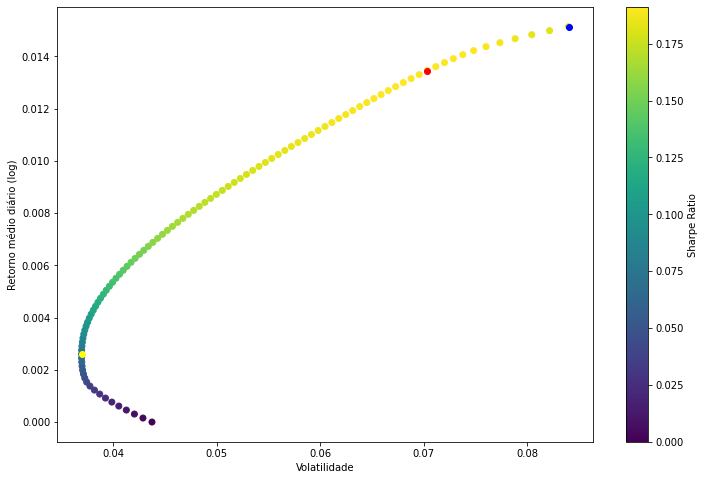

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(frontier_x, frontier_y, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno médio diário (log)')

plt.scatter(frontier_x[sr_max_index], frontier_y[sr_max_index], c='red')# máximo sharpe ratio
plt.scatter(frontier_x[retorno_max_index], frontier_y[retorno_max_index], c='blue')# máximo sharpe ratio
plt.scatter(frontier_x[volatilidade_min_index], frontier_y[volatilidade_min_index], c='yellow')# máximo sharpe ratio
plt.show()

In [7]:
variacao_periodo = (precos.iloc[-1] - precos.iloc[0]) / precos.iloc[-1]
variacao_btc = (precos.iloc[-1]["BTC"] - precos.iloc[0]["BTC"]) / precos.iloc[-1]["BTC"] * 100

### Carteira com menor volatilidade

In [8]:
imprimir_resultado(simbolos, pesos[volatilidade_min_index])

lucro = sum(variacao_periodo * pesos[volatilidade_min_index]) * 100
print("\nRentabilidade do BTC no período: " + "%.2f" % variacao_btc + "%")
print("Rentabilidade da carteira no período: " + "%.2f" % lucro + "%")
print("Volatilidade da carteira no período: " + "%.3f" % frontier_x[volatilidade_min_index])

BTC: 81.89
BNB: 6.30
ADA: 3.85
LUNA: 2.64
EGLD: 5.31

Rentabilidade do BTC no período: 23.04%
Rentabilidade da carteira no período: 24.97%
Volatilidade da carteira no período: 0.037


### Carteira com maior retorno

In [9]:
imprimir_resultado(simbolos, pesos[retorno_max_index])

lucro = sum(variacao_periodo * pesos[retorno_max_index]) * 100
print("\nRentabilidade do BTC no período: " + "%.2f" % variacao_btc + "%")
print("Rentabilidade da carteira no período: " + "%.2f" % lucro + "%")
print("Volatilidade da carteira no período: " + "%.3f" % frontier_x[retorno_max_index])

LUNA: 100.00

Rentabilidade do BTC no período: 23.04%
Rentabilidade da carteira no período: 90.20%
Volatilidade da carteira no período: 0.084


### Carteira com maior sharpe ratio

In [11]:
imprimir_resultado(simbolos, pesos[sr_max_index])

lucro = sum(variacao_periodo * pesos[sr_max_index]) * 100
print("\nRentabilidade do BTC no período: " + "%.2f" % variacao_btc + "%")
print("Rentabilidade da carteira no período: " + "%.2f" % lucro + "%")
print("Volatilidade da carteira no período: " + "%.3f" % frontier_x[sr_max_index])

SOL: 2.96
LUNA: 59.72
AVAX: 33.60
EGLD: 3.72

Rentabilidade do BTC no período: 23.04%
Rentabilidade da carteira no período: -28.23%
Volatilidade da carteira no período: 0.070


In [13]:
precos

,BTC,ETH,BNB,ADA,LINK,SOL,DOT,UNI,LUNA,AVAX,ALGO,ATOM,EGLD,LTC
Data,,,,,,,,,,,,,,
2021-06-01,36684.925781,2633.518311,362.794647,1.734753,30.699013,30.985260,22.810846,27.395233,6.303989,17.773170,0.894697,13.757418,101.428307,182.980698
2021-06-02,37575.179688,2706.125000,401.262329,1.752824,30.656301,33.956318,25.957727,27.631479,6.841399,18.677080,1.018265,14.852793,103.495209,187.263977
2021-06-03,39208.765625,2855.126465,427.807922,1.840471,32.190559,39.470905,27.013458,28.630810,7.672640,20.243713,1.109922,16.637295,107.303017,193.086182
2021-06-04,36894.406250,2688.195068,391.395325,1.710908,28.875753,37.415070,25.008299,26.442995,6.385731,18.247404,1.028761,15.084727,96.500107,178.872009
2021-06-05,35551.957031,2630.576904,390.431854,1.659009,27.126797,39.585400,23.816771,25.607552,6.055346,17.250303,0.976601,14.873798,96.853714,173.028717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-12,50098.335938,4134.453125,570.823975,1.347282,20.456585,0.824642,29.608980,16.017937,61.919449,88.109116,1.542000,24.574207,263.071075,159.203964
2021-12-13,46737.480469,3784.226807,521.011597,1.225348,17.775459,0.804570,25.971106,14.148139,52.745789,79.149628,1.321398,21.760569,234.254059,144.535904
2021-12-14,46612.632812,3745.440430,511.229370,1.222835,17.587616,0.807721,26.168419,14.979408,57.277336,87.311905,1.323860,21.213074,254.483795,146.078003


### XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [11]:
carteiras = pd.DataFrame(columns=simbolos, data=pesos)
carteiras['sharpe_ratio'] = sharpe_ratio
carteiras['volatilidade'] = frontier_x
carteiras['retorno'] = frontier_y
carteiras_formatadadas = carteiras.applymap(lambda x: "%.2f" % (x * 100) )

In [12]:
carteiras.sort_values(by=['volatilidade', 'retorno'])

,BTC,ETH,BNB,ADA,LINK,SOL,DOT,UNI,LUNA,AVAX,ALGO,ATOM,EGLD,LTC,sharpe_ratio,volatilidade,retorno
14,8.568115e-01,9.540979e-18,1.965720e-02,4.621850e-02,2.688821e-17,5.204170e-18,2.038300e-17,0.000000e+00,0.027508,0.000000e+00,0.000000e+00,2.168404e-18,4.980485e-02,0.000000e+00,0.044684,0.037126,0.001659
13,8.495288e-01,0.000000e+00,2.818856e-02,4.970413e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.013473,0.000000e+00,6.071532e-18,0.000000e+00,5.910594e-02,0.000000e+00,0.041491,0.037127,0.001540
15,8.568457e-01,1.734723e-18,1.659338e-02,3.392440e-02,0.000000e+00,0.000000e+00,1.702197e-17,0.000000e+00,0.031635,0.000000e+00,0.000000e+00,0.000000e+00,6.100142e-02,3.632077e-17,0.047869,0.037131,0.001777
12,8.466268e-01,4.271757e-17,2.591951e-02,6.565240e-02,2.165694e-17,4.391019e-18,2.602085e-18,0.000000e+00,0.009005,2.477402e-17,0.000000e+00,0.000000e+00,5.279641e-02,8.185726e-18,0.038289,0.037137,0.001422
16,8.597153e-01,0.000000e+00,1.578027e-02,2.201153e-02,0.000000e+00,0.000000e+00,1.073360e-17,1.886512e-17,0.038622,2.385245e-18,2.157562e-17,7.589415e-18,6.387063e-02,0.000000e+00,0.051036,0.037149,0.001896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000e+00,0.000000e+00,4.718448e-16,6.106227e-16,5.551115e-17,0.000000e+00,6.800116e-16,5.828671e-16,0.846494,1.535056e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.665335e-16,0.149424,0.075336,0.011257
96,0.000000e+00,6.383782e-16,2.220446e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.163336e-16,0.884871,1.151292e-01,2.220446e-16,0.000000e+00,0.000000e+00,6.383782e-16,0.148601,0.076551,0.011375
97,4.996004e-16,1.110223e-16,0.000000e+00,0.000000e+00,0.000000e+00,6.938894e-16,0.000000e+00,1.110223e-16,0.923247,7.675281e-02,0.000000e+00,0.000000e+00,5.551115e-16,4.024558e-16,0.147630,0.077857,0.011494
98,1.013079e-15,1.110223e-16,8.743006e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.961624,3.837640e-02,7.216450e-16,9.020562e-16,0.000000e+00,6.938894e-16,0.146530,0.079250,0.011612


In [13]:
pd.set_option('display.max_rows', None)
print(carteiras_formatadadas)

      BTC   ETH   BNB    ADA  LINK   SOL   DOT   UNI    LUNA   AVAX  ALGO  \
0   59.58  0.00  0.00  35.73  0.00  0.20  0.00  4.49    0.00   0.00  0.00   
1   62.33  0.00  0.00  34.66  0.00  0.14  0.00  2.87    0.00   0.00  0.00   
2   65.20  0.00  0.00  33.72  0.00  0.13  0.00  0.96    0.00   0.00  0.00   
3   68.20  0.00  0.00  31.76  0.00  0.05  0.00  0.00    0.00   0.00  0.00   
4   71.87  0.00  0.00  28.13  0.00  0.00  0.00  0.00    0.00   0.00  0.00   
5   75.80  0.00  0.00  24.20  0.00  0.00  0.00  0.00    0.00   0.00  0.00   
6   79.73  0.00  0.00  20.27  0.00  0.00  0.00  0.00    0.00   0.00  0.00   
7   81.62  0.00  0.00  17.45  0.00  0.00  0.00  0.00    0.00   0.00  0.00   
8   82.90  0.00  0.00  14.96  0.00  0.00  0.00  0.00    0.00   0.00  0.00   
9   82.84  0.00  1.27  12.62  0.00  0.00  0.00  0.00    0.00   0.00  0.00   
10  83.60  0.00  2.54   9.83  0.00  0.00  0.00  0.00    0.00   0.00  0.00   
11  84.71  0.00  2.62   7.58  0.00  0.00  0.00  0.00    0.18   0.00  0.00   

In [23]:
soma = pd.DataFrame(carteiras.sum())
soma.applymap(lambda x: "%.2f" % (x * 100) )

,0
BTC,4472.56
ETH,0.00
BNB,19.68
ADA,293.55
LINK,0.00
SOL,0.51
DOT,0.00
UNI,8.31
LUNA,3451.61
AVAX,1107.74
